In `acl.all.tsv` you'll find 7,188 papers published at major NLP venues (ACL, EMNLP, NAACL, TACL, etc.) between 2013 and 2020.  Your job is to use topic modeling to discover what topics in NLP have been increasing or decreasing in use over this time.  Here is a sample of the data we'll use:

|id|year of publication|title|abstract|
|---|---|---|---|
|pimentel-etal-2020-phonotactic|2020|Phonotactic Complexity and Its Trade-offs|We present methods for calculating a measure of phonotactic complexity---bits per phoneme--- that permits a straightforward cross-linguistic comparison. When given a word, represented as a sequence of phonemic segments such as symbols in the international phonetic alphabet, and a statistical model trained on a sample of word types from the language, we can approximately measure bits per phoneme using the negative log-probability of that word under the model. This simple measure allows us to compare the entropy across languages, giving insight into how complex a language's phonotactics is. Using a collection of 1016 basic concept words across 106 languages, we demonstrate a very strong negative correlation of − 0.74 between bits per phoneme and the average length of words.|
|wang-etal-2020-amr|2020|AMR-To-Text Generation with Graph Transformer|Abstract meaning representation (AMR)-to-text generation is the challenging task of generating natural language texts from AMR graphs, where nodes represent concepts and edges denote relations. The current state-of-the-art methods use graph-to-sequence models; however, they still cannot significantly outperform the previous sequence-to-sequence models or statistical approaches. In this paper, we propose a novel graph-to-sequence model (Graph Transformer) to address this task. The model directly encodes the AMR graphs and learns the node representations. A pairwise interaction function is used for computing the semantic relations between the concepts. Moreover, attention mechanisms are used for aggregating the information from the incoming and outgoing neighbors, which help the model to capture the semantic information effectively. Our model outperforms the state-of-the-art neural approach by 1.5 BLEU points on LDC2015E86 and 4.8 BLEU points on LDC2017T10 and achieves new state-of-the-art performances.|


First, let's read in the data and train a topic model on it (you are free to set the number of topics $K$ as you see fit.

In [42]:
K=50

In [27]:
import nltk
import re
import gensim
from gensim import corpora
import operator

nltk.download('stopwords')
from nltk.corpus import stopwords

import numpy as np
import random

random.seed(1)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dbamman/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [28]:
stop_words = stopwords.words('english')

In [29]:
def filter(word, stopwords):
    
    """ Function to exclude words from a text """
    
    # no stopwords
    if word in stopwords:
        return False
    
    # has to contain at least one letter
    if re.search("[A-Za-z]", word) is not None:
        return True
    
    return False

In [30]:
def read_docs(dataFile, stopwords):
    
    names=[]    
    docs=[]
   
    with open(dataFile, encoding="utf-8") as file:
        for line in file:
            cols=line.rstrip().split("\t")
            idd=cols[0]
            name=cols[2]
            year=int(cols[1])
        
            text=cols[3]
            
            tokens=nltk.word_tokenize(text.lower())
            tokens=[x for x in tokens if filter(x, stopwords)]
            docs.append(tokens)
            names.append((name, year))
    return docs, names

In [31]:
dataFile="../data/acl.all.tsv"
data, doc_names=read_docs(dataFile, stop_words)

We will convert the data into a bag-of-words representation using gensim's [corpora.dictionary](https://radimrehurek.com/gensim/corpora/dictionary.html) methods.

In [32]:
# Create vocab from data; restrict vocab to only the top 10K terms that show up in at least 5 documents 
# and no more than 50% of all documents

dictionary = corpora.Dictionary(data)
dictionary.filter_extremes(no_below=5, no_above=.5, keep_n=10000)

In [33]:
# Replace dataset with numeric ids words in vocab (and exclude all other words)
corpus = [dictionary.doc2bow(text) for text in data]

Now let's run a topic model on this data using gensim's built-in LDA.

In [43]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=K, 
                                           passes=10,
                                           alpha='auto')

We can get a sense of what the topics are by printing the top 10 words with highest $P(word \mid topic)$ for each topic

In [44]:
for i in range(K):
    print("topic %s:\t%s" % (i, ' '.join([term for term, freq in lda_model.show_topic(i, topn=10)])))

topic 0:	attention mechanism mechanisms multi-modal ii compression negation heads head iii
topic 1:	visual multimodal images video objects grounded object image actions modalities
topic 2:	latent semantic representation structure structures generative representations meaning inference variables
topic 3:	segmentation structured input output prediction token sequence tokens constraints segments
topic 4:	user news unsupervised users clustering approach supervised representations recommendation seed
topic 5:	summarization document bias summaries documents text abstractive summary extractive dataset
topic 6:	question questions answer answering qa reading comprehension dataset answers reasoning
topic 7:	models language natural inference tasks neural show training however learning
topic 8:	language dataset annotation available corpus natural new research present annotated
topic 9:	human models predictions game explanations humans interpretable explanation neural text
topic 10:	system evaluati

Now let's print out the documents that have the highest topic representation -- i.e., for a given topic $k$, the documents with highest $P(topic=k | document)$ -- in order to ground these topic summaries with actual documents that contain those topics.

In [45]:
topic_model=lda_model 

topic_docs=[]
for i in range(K):
    topic_docs.append({})
for doc_id in range(len(corpus)):
    doc_topics=topic_model.get_document_topics(corpus[doc_id])
    for topic_num, topic_prob in doc_topics:
        topic_docs[topic_num][doc_id]=topic_prob

for i in range(K):
    print("%s\n" % ' '.join([term for term, freq in topic_model.show_topic(i, topn=10)]))
    sorted_x = sorted(topic_docs[i].items(), key=operator.itemgetter(1), reverse=True)
    for k, v in sorted_x[:5]:
        print("%s\t%.3f\t%s" % (i,v,doc_names[k]))
    print()
    
    

attention mechanism mechanisms multi-modal ii compression negation heads head iii

0	0.507	('Attention is Not Only a Weight: Analyzing Transformers with Vector Norms', 2020)
0	0.340	('Adaptively Sparse Transformers', 2019)
0	0.291	("``You Sound Just Like Your Father'' Commercial Machine Translation Systems Include Stylistic Biases", 2020)
0	0.283	('Surprisingly Easy Hard-Attention for Sequence to Sequence Learning', 2018)
0	0.281	('BERT-of-Theseus: Compressing BERT by Progressive Module Replacing', 2020)

visual multimodal images video objects grounded object image actions modalities

1	0.594	('VQD: Visual Query Detection In Natural Scenes', 2019)
1	0.503	('Learning to Segment Actions from Observation and Narration', 2020)
1	0.394	('Video2Commonsense: Generating Commonsense Descriptions to Enrich Video Captioning', 2020)
1	0.369	('TVQA+: Spatio-Temporal Grounding for Video Question Answering', 2020)
1	0.359	('Identifying Visible Actions in Lifestyle Vlogs', 2019)

latent semantic repre

**Q1**: Use this basic framework to plot the distribution of a topic over time (between the years 2013-2020).  Specifically, given a document-topic distribution $\theta$ for an entire corpus such that $\theta_d$ is the document-topic distribution for document $d$ and $\theta_{d,i}$ is the probability of topic $i$ in document $d$, the relative frequency of topic $i$ at time $t$ is the sum of $\theta_{d,i}$ for all documents that are published in year $t$, divided by the total number of documents published in year $t$: 

$$
f(t, i) ={ \sum_{d \in D: date(d) = t} \theta_{d,i} \over \sum_{d \in D: date(d) = t} 1}
$$

For all of the $K$ topics you learn above, plot the distribution of that topic over time (i.e., the x-axis should be time from 2013-2020 and the y-axis should be the relative frequency value $f$ defined above).  Your output here should be $K$ line charts paired with their topic signatures (e.g., from `topic_model.show_topic`, so that we know what topic the chart corresponds to).  See below for sample code generating such a line chart with x, y inputs.

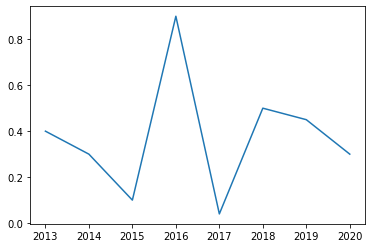

In [46]:
import matplotlib.pyplot as plt

a=[2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]
b=[0.4, 0.3, 0.1, 0.9, 0.04, 0.5, 0.45, 0.3 ]

def plot_category(a,b):
    plt.plot(a,b)
    plt.show()

plot_category(a,b)

attention mechanism mechanisms multi-modal ii compression negation heads head iii



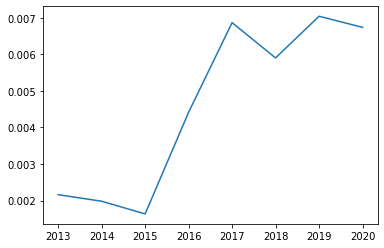

visual multimodal images video objects grounded object image actions modalities



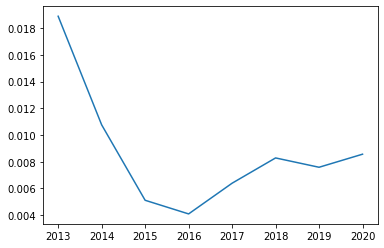

latent semantic representation structure structures generative representations meaning inference variables



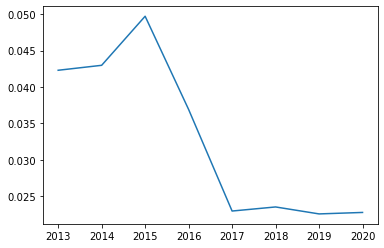

segmentation structured input output prediction token sequence tokens constraints segments



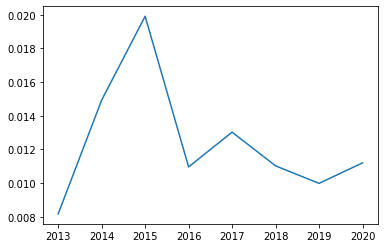

user news unsupervised users clustering approach supervised representations recommendation seed



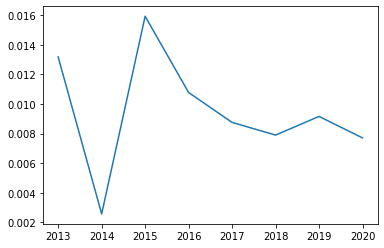

summarization document bias summaries documents text abstractive summary extractive dataset



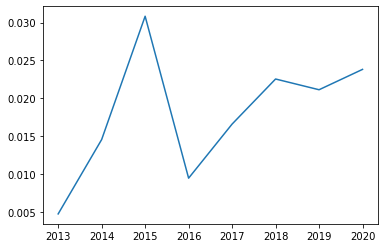

question questions answer answering qa reading comprehension dataset answers reasoning



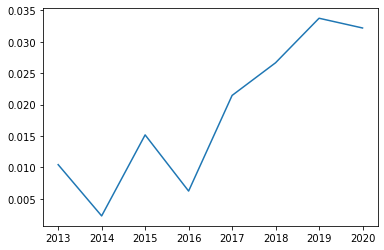

models language natural inference tasks neural show training however learning



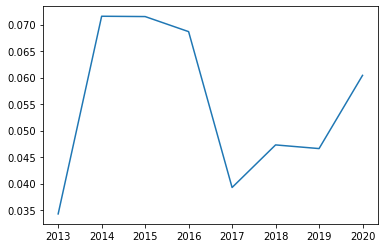

language dataset annotation available corpus natural new research present annotated



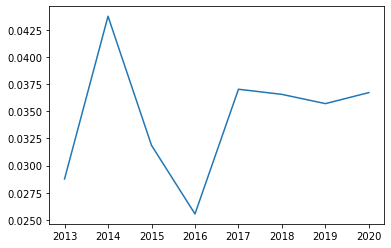

human models predictions game explanations humans interpretable explanation neural text



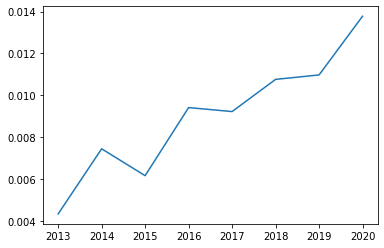

system evaluation task systems metrics human shared automatic paper metric



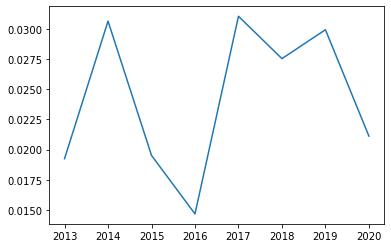

graph graphs alignment amr nodes graph-based link system el edges



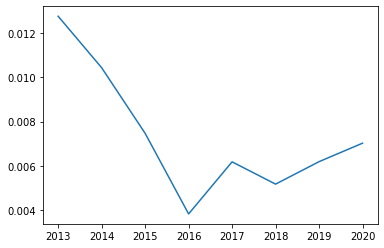

translation machine nmt neural bleu source quality translations target sentence



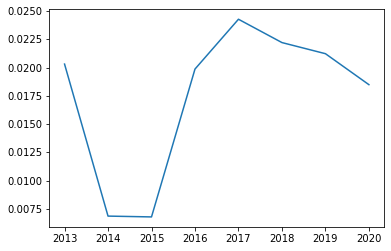

languages language multilingual cross-lingual english morphological data transfer across monolingual



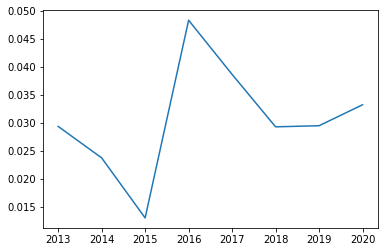

emotion dimensions emotions dialog response co-occurrence emotional responses behaviors speaker



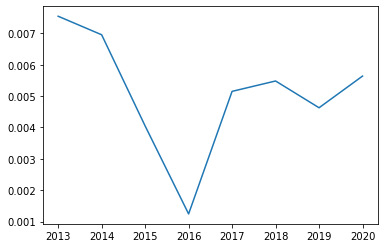

tasks task memory learning coreference multi-task neural resolution approach retrieval



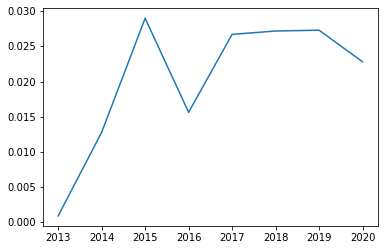

knowledge reasoning base external commonsense kb facts bases text entities



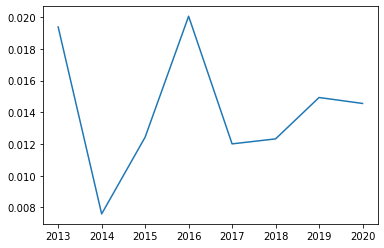

dialogue conversation dialog conversational utterances conversations systems user agents utterance



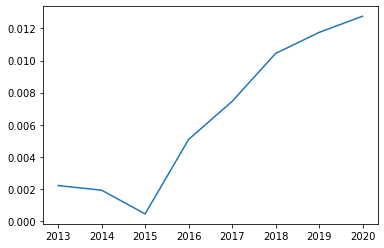

reviews aspect aspects opinion review opinions popularity financial stock market



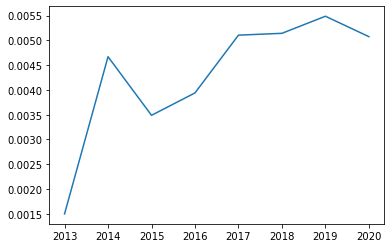

parsing discourse parser dependency treebank parsers treebanks transition-based transition system



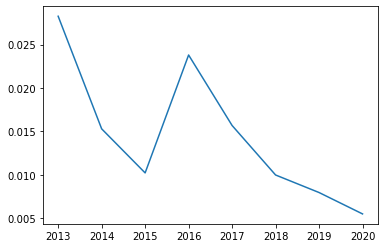

syntactic dependency parsing tagging tree trees dependencies structure syntax pos



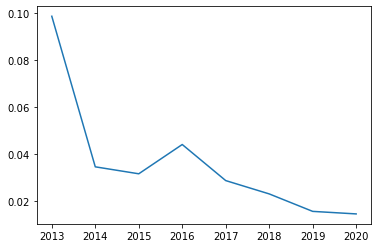

semantic parsing accuracy training new logical parser approach using time



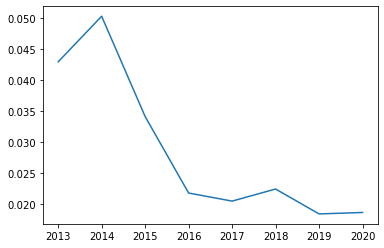

propose proposed neural results two generation datasets paper show methods



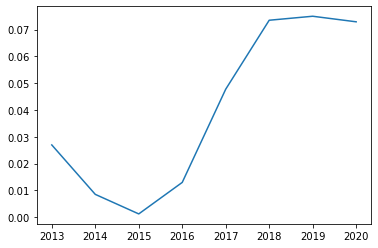

learning problem method framework methods knowledge proposed approach results show



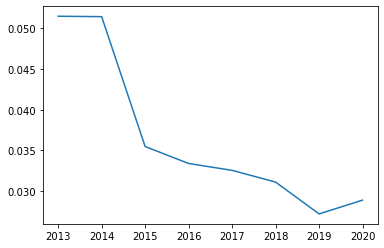

models neural features speech network using text recognition sequence use



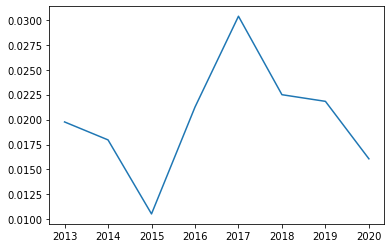

et al. algorithm sense grammar al algorithms disambiguation grammars induction



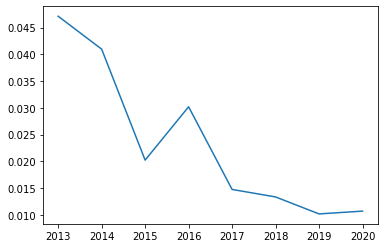

domain domains method performance classification data adaptation target training learning



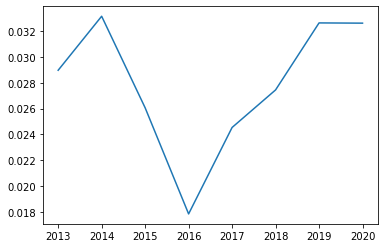

argument arguments detection evidence sarcasm claim features fact task claims



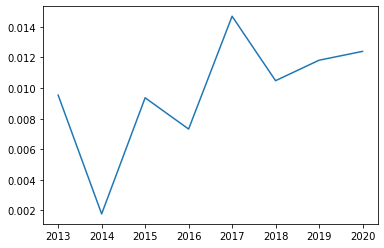

categories product attributes speech category attribute features values prediction predictive



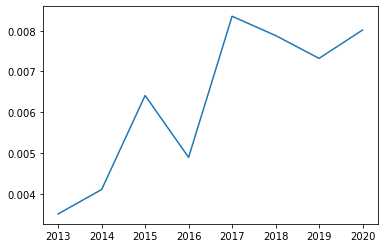

metaphor identification first noun expressions challenge e.g document ranking effects



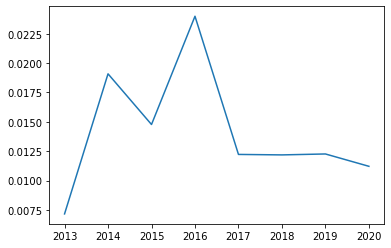

information neural sentence network networks local global context results two



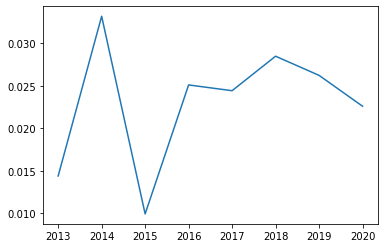

style transfer relevance corpus content writing responses elements target control



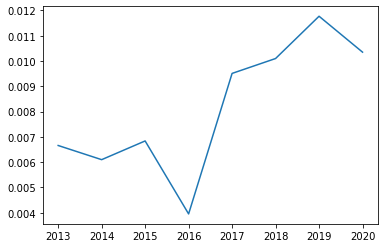

social media information data users texts twitter tweets detection clinical



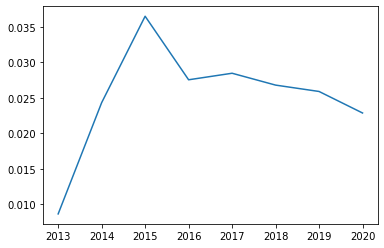

generation text human language image models descriptions dataset automatic generate



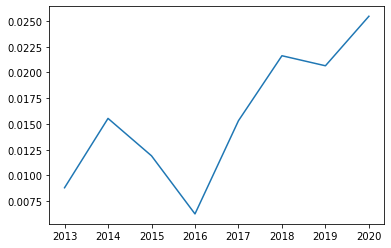

tasks bert language models pre-trained code fine-tuning performance pre-training encoder



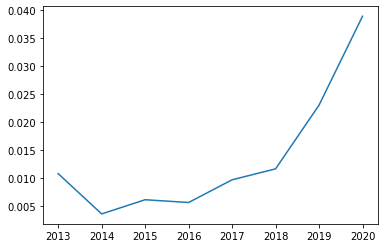

relation relations extraction labels supervision distant label supervised noisy learning



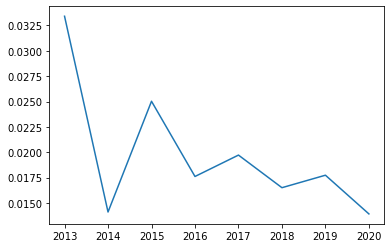

sentiment analysis classification polarity senses lattice words specific aspect intensity



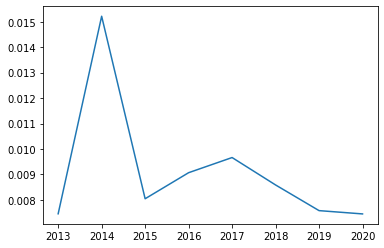

gender kg author mrc authors metadata person names chat age



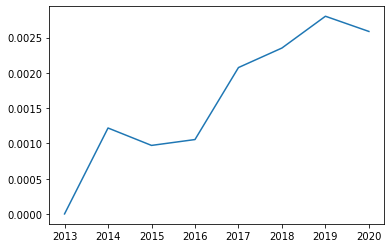

word embeddings words embedding space method lexicon similarity bilingual methods



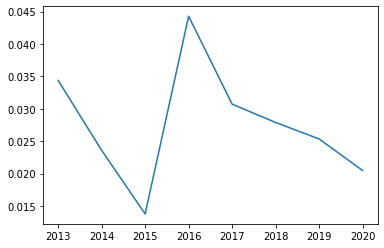

entity entities event named ner events mentions recognition linking type



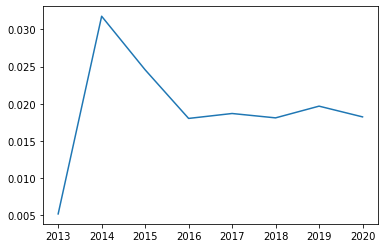

representations deep layers tasks performance neural recurrent state-of-the-art using network



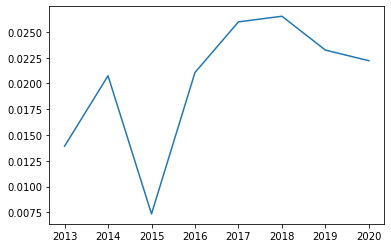

topic news topics articles article online coherence wikipedia argumentation quality



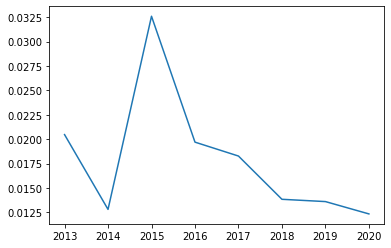

temporal time constraints historical normalization cnns gradient decisions constraint changes



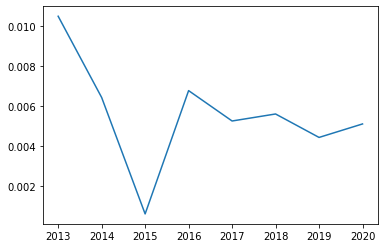

search decoding art state role srl semantic labeling simplification beam



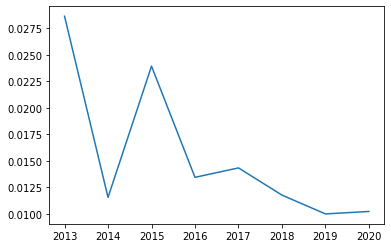

nlp research tutorial language analysis computational methods recent techniques processing



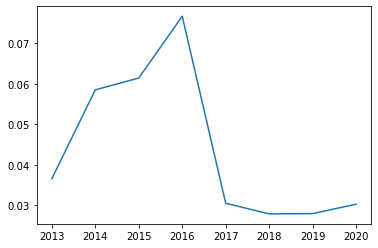

word semantic representations embeddings words embedding representation lexical similarity vector



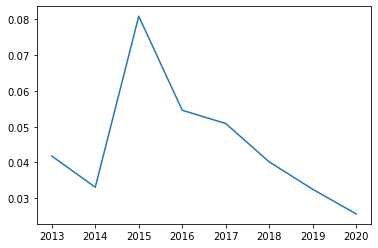

error errors grammatical performance correction reduction gec random algorithms correct



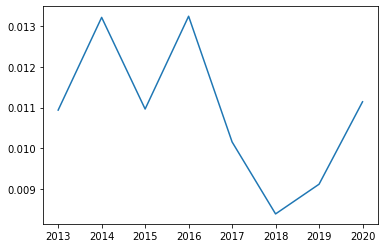

concepts concept language comments environment natural agent tasks 's instructions



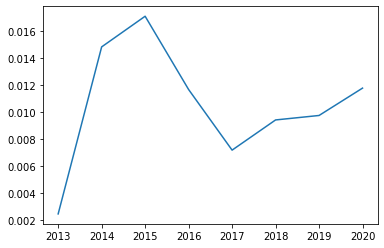

data training large learning labeled methods models supervised show using



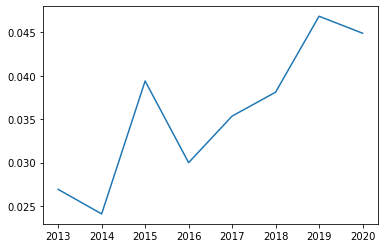

training models adversarial neural networks show performance robustness examples propose



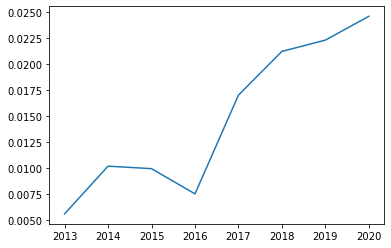

In [48]:
topic_model=lda_model 

start=2013
end=2021

window=end-start

topic_docs=[]
total_mass=np.zeros(window)

for i in range(K):
    topic_docs.append(np.zeros(window))
    
for doc_id in range(len(corpus)):
    doc_topics=topic_model.get_document_topics(corpus[doc_id])
    title, year=doc_names[doc_id]
    total_mass[year-start]+=1
    for topic_num, topic_prob in doc_topics:
        topic_docs[topic_num][year-start]+=topic_prob

for i in range(K):
    print("%s\n" % ' '.join([term for term, freq in topic_model.show_topic(i, topn=10)]))
    plot_category(range(2013,2021), topic_docs[i]/total_mass)
    
    
    